# Model 3 : transformers applied to time series forecasting

## Imports and Data pre-processing

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(0)
np.random.seed(0)

In [129]:
from google.colab import drive
WEATHER_DATA_PATH = "/content/gdrive/MyDrive/Machine Learning/Datasets/weather_forecasting"
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [130]:
path = '/home/rbazin/ECSE552/ECSE552-HW4/'

In [132]:
def custom_date_parser(date_string):
    return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')

In [133]:
data = pd.read_csv(os.path.join(WEATHER_DATA_PATH, "weather_train.csv"), parse_dates = ['Date Time'], date_parser=custom_date_parser)
data.head()

<ipython-input-132-806ade3554b6>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [134]:
data.sort_values(by='Date Time', ascending=True, inplace=True)

In [135]:
data = data.rename(columns={'p (mbar)': 'p', 'T (degC)': 'T', 'rh (%)': 'rh', 'wv (m/s)': 'wv', 'Date Time': 'date'})

In [136]:
data['date'] = data['date'].apply(lambda x: x.replace(minute=0))

In [137]:
data.drop("date", inplace=True, axis=1)

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56072 entries, 0 to 56071
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p                56072 non-null  float64
 1   T                56072 non-null  float64
 2   Tpot (K)         56072 non-null  float64
 3   Tdew (degC)      56072 non-null  float64
 4   rh               56072 non-null  float64
 5   VPmax (mbar)     56072 non-null  float64
 6   VPact (mbar)     56072 non-null  float64
 7   VPdef (mbar)     56072 non-null  float64
 8   sh (g/kg)        56072 non-null  float64
 9   H2OC (mmol/mol)  56072 non-null  float64
 10  rho (g/m**3)     56072 non-null  float64
 11  wv               56072 non-null  float64
 12  max. wv (m/s)    56072 non-null  float64
 13  wd (deg)         56072 non-null  float64
dtypes: float64(14)
memory usage: 6.4 MB


In [139]:
data_df = data.copy()

In [140]:
# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the DataFrame using MinMaxScaler
data_df[data_df.columns] = scaler.fit_transform(data_df)
data_df.head()

,p,T,Tpot (K),Tdew (degC),rh,VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv,max. wv (m/s),wd (deg)
0,0.652876,-0.496319,-0.506454,-0.330547,0.869949,-0.917727,-0.830175,-0.990905,-0.834852,-0.832438,0.487084,-0.970021,-0.946383,0.070556
1,0.655269,-0.524739,-0.534986,-0.371918,0.842081,-0.925048,-0.847668,-0.989947,-0.851936,-0.849624,0.513365,-0.964311,-0.946383,0.057222
2,0.659655,-0.522342,-0.533288,-0.367321,0.849048,-0.924699,-0.845481,-0.990426,-0.849658,-0.847476,0.512946,-0.974304,-0.946383,-0.071111
3,0.662646,-0.530560,-0.541780,-0.382365,0.828147,-0.926791,-0.851312,-0.988990,-0.855353,-0.853921,0.521506,-0.985724,-0.967660,0.333333
4,0.672017,-0.550419,-0.562840,-0.408692,0.818857,-0.931323,-0.861516,-0.988990,-0.865604,-0.863946,0.542938,-0.942898,-0.925106,-0.127778


## Model architecture

First, we build the architecture :

In [141]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

In [142]:
class TimeFormer(nn.Module):
    def __init__(self,feature_size=250,num_encoder_layers=1,dropout=0.1, nbr_labels=4):
        super(TimeFormer, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(nbr_labels, feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers, norm=None)
        self.decoder = nn.Linear(feature_size * nbr_labels, nbr_labels)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != src.shape[1]:
            device = src.device
            mask = self._generate_square_subsequent_mask(src.shape[1]).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src) # positional embedding
        output = self.transformer_encoder(src,self.src_mask) # transformer encoder
        output = output.reshape(output.shape[0], -1) # flatten the output
        output = self.decoder(output)  # linear transformation decoder
        return output

    def _generate_square_subsequent_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


We create the a dataset class to encapsulate and format our data :

In [143]:
class TimeFormerDataset(Dataset):
    """
    Dataset class used for TimeFormer model.
    """
    def __init__(self, data_df, enc_seq_len=4, window_step=1, labels_as_features=False):
        super().__init__()

        self.enc_seq_len = enc_seq_len
        self.window_step = window_step

        self.labels = torch.from_numpy(data_df.loc[:, ["p", "T", "rh", "wv"]].to_numpy()).type(torch.float32)
        self.features = None
        if not labels_as_features:
            self.features = torch.from_numpy(data_df.loc[:, [k for k in data_df.columns if k not in ["p", "T", "rh", "wv", "date"]]].to_numpy()).type(torch.float32)

        # list of tuple (start, end) of the sequences according to window_step and enc_seq_len
        self.seq_list = [(i, i + enc_seq_len) for i in range(0, len(data_df) - enc_seq_len, window_step)]
    
    def __len__(self):
        return len(self.seq_list)
    
    def __getitem__(self, idx):
        """ 
        Returns the input and target sequences for a given index.
        """

        # get the start and end of the sequence
        start, end = self.seq_list[idx]

        # get the input sequence
        src_seq = self.features[start:end] if self.features is not None else self.labels[start:end]
        trgt_seq = self.labels[end]

        return src_seq, trgt_seq.squeeze()

## Training

In [144]:
# training function
def train(model, criterion, optimizer, scheduler, epochs, train_loader, val_loader, device, save_path):
    
    train_losses = []
    val_losses = []
    lrs = []
    pbar = tqdm(range(epochs), desc="Epochs", leave=True, position=0)

    start = time.time()
    for i, epoch in enumerate(pbar):

        total_loss = 0.
        lrs.append(optimizer.param_groups[0]['lr'])
        model.train()
        for batch in train_loader:  
            
            srcs = batch[0].to(device)
            trgts = batch[1].to(device)

            optimizer.zero_grad()
            output = model(srcs)
            loss = criterion(output, trgts)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            optimizer.step()

            total_loss += loss.item()
        
        train_losses.append(total_loss / len(train_loader))

        # validation
        total_loss = 0.
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                srcs = batch[0].to(device)
                trgts = batch[1].to(device)

                output = model(srcs)
                loss = criterion(output, trgts)

                total_loss += loss.item()
            
            val_losses.append(total_loss / len(val_loader))
        
        # update scheduler
        #scheduler.step(val_losses[-1])
        if scheduler is not None:
          scheduler.step()

        pbar.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], lr=lrs[-1])
        
        # checkpoint
        if i % 10 == 0:
            torch.save(model.state_dict(), save_path)
    
    end = time.time()
    print(f"Training time: {end - start:.2f} seconds")
    
    return model, train_losses, val_losses, lrs

In [145]:
# evaluation function
def evaluate(model, criterion, test_loader, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0.
        for batch in test_loader:
            srcs = batch[0].to(device)
            trgts = batch[1].to(device)

            output = model(srcs)
            loss = criterion(output, trgts)

            total_loss += loss.item()
        
        return total_loss / len(test_loader)

In [146]:
# hyperparameters
epochs = 25
lr = 1e-3
enc_seq_len = 4 # number of past observations to use
window_step = 1 # step between two consecutive windows
nbr_labels = 4 # number of labels to predict
batch_size = 32
dropout = 0.1
num_encoder_layers = 1 # number of transformer encoder layers
feature_size = 250 # size of the feature vector in the input embedding layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


In [147]:
# datasets and dataloaders
time_ds = TimeFormerDataset(data_df, enc_seq_len=enc_seq_len, window_step=window_step, labels_as_features=True)

train_size = int(0.9 * len(time_ds)) # 90% for training
val_size = len(time_ds) - train_size

train_ds, val_ds = random_split(time_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [148]:
# training 

model = TimeFormer(nbr_labels=nbr_labels, feature_size=feature_size, num_encoder_layers=num_encoder_layers, dropout=dropout).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=False)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

model, train_losses, val_losses, lrs = train(model, criterion, optimizer, None, epochs, train_loader, val_loader, device, "timeformer.pth")

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
Epochs: 100%|██████████| 25/25 [05:10<00:00, 12.44s/it, lr=0.001, train_loss=0.00653, val_loss=0.00673]

Training time: 310.98 seconds


In [149]:
print("Saving final model")
torch.save(model.state_dict(), "timeformer_final.pth")

Saving final model


In [150]:
print(f"Final losses | Train loss: {train_losses[-1]:.4f} | Val loss: {val_losses[-1]:.4f}")

Final losses | Train loss: 0.0065 | Val loss: 0.0067


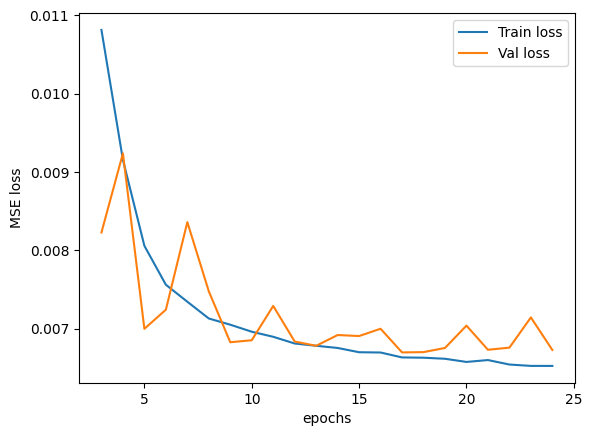

In [151]:
# plot losses
start_epoch = 3
plt.plot(list(range(start_epoch, len(train_losses))), train_losses[start_epoch:], label="Train loss")
plt.plot(list(range(start_epoch, len(train_losses))), val_losses[start_epoch:], label="Val loss")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.legend()

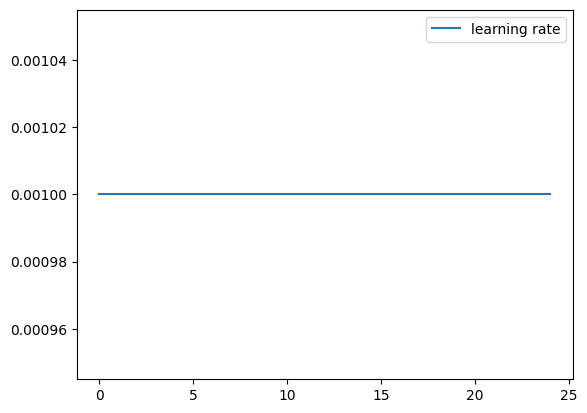

In [152]:
# plot lr
plt.plot(lrs, label="learning rate")
plt.legend()

## Evaluation

In [153]:
test_df = pd.read_csv(os.path.join(WEATHER_DATA_PATH, "weather_test.csv"), parse_dates = ['Date Time'], date_parser=custom_date_parser)
test_df.head()

<ipython-input-132-806ade3554b6>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2015-05-24 19:00:00,990.00,17.93,291.93,9.23,56.73,20.58,11.68,8.91,7.37,11.79,1179.50,1.58,2.16,34.37
1,2015-05-24 20:00:00,989.86,16.92,290.93,9.52,61.65,19.31,11.90,7.40,7.51,12.03,1183.33,0.23,0.60,20.89
2,2015-05-24 21:00:00,990.11,15.82,289.80,9.71,66.97,18.00,12.06,5.95,7.61,12.18,1188.07,0.26,0.52,252.00
3,2015-05-24 22:00:00,990.01,15.02,289.01,9.50,69.53,17.10,11.89,5.21,7.50,12.01,1191.32,1.22,1.88,218.50
4,2015-05-24 23:00:00,989.89,14.14,288.14,9.42,73.20,16.15,11.83,4.33,7.46,11.95,1194.85,1.43,1.96,218.00


In [154]:
test_df.sort_values(by='Date Time', ascending=True, inplace=True)

In [155]:
test_df = test_df.rename(columns={'p (mbar)': 'p', 'T (degC)': 'T', 'rh (%)': 'rh', 'wv (m/s)': 'wv', 'Date Time': 'date'})

In [156]:
test_df['date'] = test_df['date'].apply(lambda x: x.replace(minute=0))

In [157]:
test_df.drop('date', inplace=True, axis=1)

In [158]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14019 entries, 0 to 14018
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p                14019 non-null  float64
 1   T                14019 non-null  float64
 2   Tpot (K)         14019 non-null  float64
 3   Tdew (degC)      14019 non-null  float64
 4   rh               14019 non-null  float64
 5   VPmax (mbar)     14019 non-null  float64
 6   VPact (mbar)     14019 non-null  float64
 7   VPdef (mbar)     14019 non-null  float64
 8   sh (g/kg)        14019 non-null  float64
 9   H2OC (mmol/mol)  14019 non-null  float64
 10  rho (g/m**3)     14019 non-null  float64
 11  wv               14019 non-null  float64
 12  max. wv (m/s)    14019 non-null  float64
 13  wd (deg)         14019 non-null  float64
dtypes: float64(14)
memory usage: 1.6 MB


In [159]:
test_df[test_df.columns] = scaler.transform(test_df)

In [160]:
test_ds = TimeFormerDataset(test_df, enc_seq_len=enc_seq_len, window_step=window_step, labels_as_features=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
test_loss = evaluate(model, criterion, test_loader, device)
print(f"Test loss: {test_loss:.4f}")